# 1. E-Cell4を用いたシミュレーションの短いツアー

まず下記のようにプロットライブラリ(matplotlib)とE-Cell4ライブラリを読み込む必要があります

In [1]:
%matplotlib inline
from ecell4 import *

## 1.1. クイックデモ

E-Cell4には `Model`, `World`, `Simulator` の3つの基本コンポーネントがあります．
これらのコンポーネントはシミュレーションにおける下記の概念を記述します．

* `Model` はその名の通りシミュレートする内容を記述します．
* `World` はある状態を記述します．例えば初期条件やあるタイムポイントでの状態などです．
* `Simulator` はソルバーについて記述します.

`Model` はソルバーから独立しています。
すべてのソルバーは、単一の `Model` インスタンスを共有することができます。
各ソルバーのアルゴリズムには対応する `World` と `Simulator` のペアがあります（これらのペアは `Factory` クラスにカプセル化されています）．
`World` は必ずしも `Model` と `Simulator` に結びついている必要はありませんが，`Simulator` は `Model` と `World` の両方が必要です．

シミュレーションを実行する前に `Model` を作成する必要があります．
E-Cell4は `Model` を構築するための複数の方法をサポートしています．
([モデルの構築方法](tutorial2-ja.ipynb)も参照してください．)
ここでは `reaction_rules` 関数と `with` ステートメントを使用する最も簡単な方法を説明します．


In [2]:
with reaction_rules():
    A + B > C | 0.01  # equivalent to create_binding_reaction_rule
    C > A + B | 0.3   # equivalent to create_unbinding_reaction_rule

m1 = get_model()
print(m1)

`reaction_rules` の後に括弧（）を書くことを覚えておいてください．
ここでは、`m1` という名前の2つの `ReactionRule` を持つモデルが作成されました．
`with` ブロックの行は、それぞれ結合と乖離の `ReactionRule` を表しています．
質量作用の法則を示す反応の速度はセパレーター `|` の後に定義します．
すなわち `0.01` もしくは `0.3` が反応速度になります．
通常の微分方程式の形では，このモデルは次のように記述できます．

$$[\mathrm{A}]'=[\mathrm{B}]'=-[\mathrm{C}]=-0.01[\mathrm{A}][\mathrm{B}]+0.3[\mathrm{C}]$$

よりコンパクトな記述として
`A + B == C | (0.01, 0.3)` と書くことも可能です．

E-Cell4には、`run_simulation` という特定のモデルでシミュレーションを実行するためのシンプルなインターフェイスがあります。
これにより、自分で `World` と` Simulator` をインスタンス化せずにシミュレーションを実行することができます。
(ただモデルを解くには、ボリューム、各種の初期値と時間は与えなければなりません。)

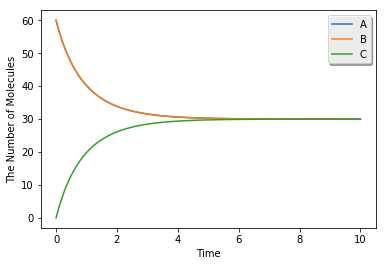

In [3]:
run_simulation(10.0, model=m1, y0={'A': 60, 'B': 60}, volume=1.0)

シミュレーションアルゴリズムを切り替えるのは、次のようにソルバの型を指定するだけでできます。
( デフォルトでは `ode` が使われるようになっています)

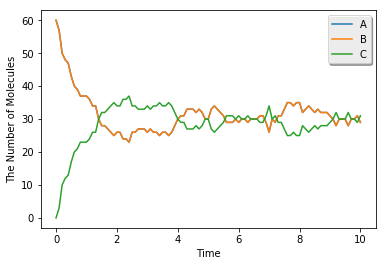

In [4]:
run_simulation(10.0, model=m1, y0={'A': 60, 'B': 60}, solver='gillespie')

## 1.2. 空間シミュレーションと可視化

E-Cell4は、複数の空間シミュレーションアルゴリズム、`egfrd`、`spatiocyte`、`meso` をサポートするようになりました。 これらの空間ソルバーは、非空間ソルバー ( `ode` および `gillespie` ) で使用されるモデルに加えて、各 `Species` についての追加の情報 (拡散係数および半径) を必要とします。

`species_attributes` を持つ ` with` ステートメントは、これらのプロパティ情報を記述するために利用できます：


In [5]:
with species_attributes():
    A | B | C | {'radius': '0.005', 'D': '1'}  # 'D' is for the diffusion coefficient

with reaction_rules():
    A + B == C | (0.01, 0.3)

m2 = get_model()

プロパティーは浮動小数点数を表しますが、各属性は文字列として指定する必要があります。

今度は、上記と同じ方法で空間シミュレーションを実行できます (`egfrd` の場合、シミュレーションし終わるまでにかかる時間は長くなります)。


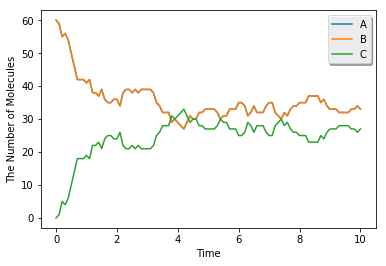

In [6]:
run_simulation(10.0, model=m2, y0={'A': 60, 'B': 60}, solver='meso')

`Structure` (例えば 膜、細胞質および核といったもの) は、今のところ `spatiocyte` および `meso` でのみのサポートとなっています。
シミュレーションのための各 `Species` が属する `location` は、その属性で指定しなければなりません。


In [7]:
with species_attributes():
    A | {'D': '1', 'location': 'S'}  # 'S' is a name of the structure

m3 = get_model()  # with no reactions

E-Cell4はプリミティブなシェイプを `Sphere` のような構造体としてサポートしています：


In [8]:
sphere = Sphere(Real3(0.5, 0.5, 0.5), 0.48)  # a center position and radius

E-Cell4は、シミュレーション中に状態を記録する様々な種類の `Observer` を提供しています。
下記では2つの `Observer` が分子の位置を記録すると宣言されています。
`FixedIntervalTrajectoryObserver` は分子の軌跡を記録し、` FixedIntervalHDF5Observer` は `World` を与えられた時間間隔でHDF5ファイルに保存します：


In [9]:
obs1 = FixedIntervalTrajectoryObserver(1e-3)
obs2 = FixedIntervalHDF5Observer(0.1, 'test%02d.h5')

`run_simulation` は構造体とオブザーバを引数 `structures` と `observers` として受け取りることができます（` help（run_simulation） `も参照してください）：


In [10]:
run_simulation(1.0, model=m3, y0={'A': 60}, structures={'S': sphere},
               solver='spatiocyte', observers=(obs1, obs2), return_type=None)

E-Cell4には、`viz.plot_world` というインタラクティブな視覚化が可能な `World` を視覚化する機能があります。
`viz.plot_world` は、分子の位置を3Dでプロットします。
さらに、`load_world` を使用することで、HDF5ファイルからWorldの状態を簡単に復元することができます。

In [12]:
# viz.plot_world(load_world('test00.h5'), species_list=['A'])
viz.plot_world(load_world('test00.h5'), species_list=['A'], interactive=True)

また、 `FixedIntervalTrajectoryObserver` の場合、`viz.plot_trajectory` は軌道のプロットを生成します。(ここでもインタラクティブなプロットの生成が可能です。)：


In [13]:
# viz.plot_trajectory(obs1)
viz.plot_trajectory(obs1, interactive=True)

より詳しくは [5. How to Log and Visualize Simulations](tutorial5-ja.ipynb) を参照してください。